<a href="https://colab.research.google.com/github/Apaulgithub/CodeClauseInternship_Price_Recommendation/blob/main/Price_Recommendation_for_Online_Sellers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project Name**    - Price Recommendation for Online Sellers


## ***1. Know Your Data***

### Import Libraries

In [1]:
# Import Libraries
# Importing Numpy & Pandas for data processing & data wrangling
import numpy as np
import pandas as pd

# Importing  tools for visualization
import matplotlib.pyplot as plt
import seaborn as sns
import gc

# Import functions to work with sparse matrices
from scipy.sparse import vstack, hstack, csr_matrix

# Library used for textual data preprocessing
import string
from string import punctuation
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold

# Import LabelBinarizer to convert labels into numerical representations
from sklearn.preprocessing import LabelBinarizer

# Import the ML models for regression tasks
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

# Import time format
import time

# Library used for ignore warnings
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Dataset Loading

In [2]:
# Mount with Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load Train Dataset from github repository
train = pd.read_csv('/content/drive/My Drive/Data Science Internships/Code Clause/Price Recommendation for Online Sellers/Project CSV File/train.tsv', sep = '\t')

In [4]:
# Load Test Dataset from github repository
test = pd.read_csv('/content/drive/My Drive/Data Science Internships/Code Clause/Price Recommendation for Online Sellers/Project CSV File/test.tsv', sep = '\t')

In [5]:
# Create combined set.
combined = pd.concat([train,test])

# Create the submission set (Only contains the test ID)
submission = test[['test_id']]

# Create size of train
train_size = len(train)

# Create log price variable (Transformation)
y = np.log1p(train['price'])

# Selecting 10% of the combined dataset and resetting the index for the new subset.
combined_ML = combined.sample(frac=0.1).reset_index(drop=True)

### Dataset First View

In [6]:
# Dataset First Look
# View top 5 rows of the dataset
combined_ML.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,test_id
0,86695.0,Authentic Jason Williams Jersey,2,Men/Athletic Apparel/Jerseys,Starter,81.0,0,Starter Authentic Sacramento Kings Jason Willi...,NaN
1,998048.0,Joes the skinny size 29,4,"Women/Jeans/Slim, Skinny",Joe's Jeans,16.0,0,Some spandex pulls shown in second picture not...,NaN
2,72764.0,Victoria's Secret Knockout Tights,2,"Women/Athletic Apparel/Pants, Tights, Leggings",Victoria's Secret,33.0,0,Bought these on here but too tight for me :( S...,NaN
3,452571.0,VS PINK Ballet Wrap Leggings S PREOWNED,3,"Women/Athletic Apparel/Pants, Tights, Leggings",PINK,25.0,1,Bundle: NwT Watermelon and Pineapple Shorties ...,NaN
4,NaN,Necklace and 2 stickers,1,Women/Jewelry/Necklaces,NaN,NaN,1,No description yet,680168.0


### Dataset Rows & Columns count

In [7]:
# Dataset Rows & Columns count
# Checking number of rows and columns of the dataset using shape
print("Number of rows are: ",combined_ML.shape[0])
print("Number of columns are: ",combined_ML.shape[1])

Number of rows are:  217589
Number of columns are:  9


### Dataset Information

In [8]:
# Dataset Info
# Checking information about the dataset using info
combined_ML.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217589 entries, 0 to 217588
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   train_id           147946 non-null  float64
 1   name               217589 non-null  object 
 2   item_condition_id  217589 non-null  int64  
 3   category_name      216668 non-null  object 
 4   brand_name         124768 non-null  object 
 5   price              147946 non-null  float64
 6   shipping           217589 non-null  int64  
 7   item_description   217588 non-null  object 
 8   test_id            69643 non-null   float64
dtypes: float64(3), int64(2), object(4)
memory usage: 14.9+ MB


#### Duplicate Values

In [9]:
# Dataset Duplicate Value Count
dup = combined_ML.duplicated().sum()
print(f'number of duplicated rows are {dup}')

number of duplicated rows are 0


#### Missing Values/Null Values

In [10]:
# Missing Values/Null Values Count
combined_ML.isnull().sum()

train_id              69643
name                      0
item_condition_id         0
category_name           921
brand_name            92821
price                 69643
shipping                  0
item_description          1
test_id              147946
dtype: int64

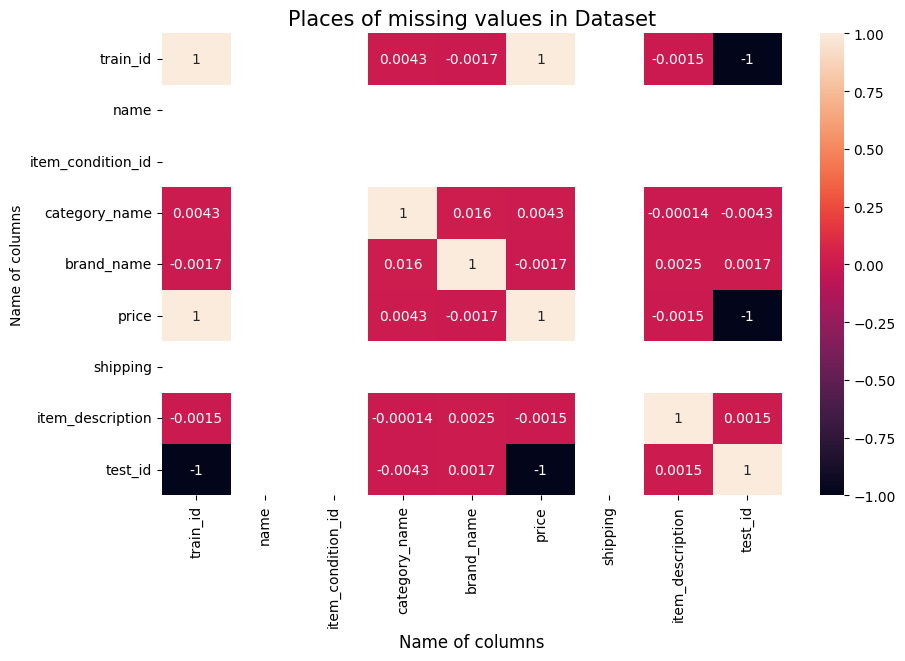

In [11]:
# Visualizing the missing values
# Set the plot size
plt.figure(figsize = (10,6))

# Create the figure object
sns.heatmap(combined_ML.isnull().corr(), vmin=-1, annot= True)

# Set labels
plt.xlabel('Name of columns', fontsize=12)
plt.ylabel('Name of columns', fontsize=10)
plt.title('Places of missing values in Dataset', fontsize=15)

# To show
plt.show()


### What did you know about your dataset?

* The dataset consists of product name, category, brand name, price etc. of different online products available in the dataset.
* There are 217589 rows and 9 columns provided in the data.
* Null values are present in train_id, test_id, price, brand_name, category_name, and item_description.
* No duplicate values exist.

## ***2. Understanding Your Variables***

In [12]:
# Dataset Columns
combined_ML.columns

Index(['train_id', 'name', 'item_condition_id', 'category_name', 'brand_name',
       'price', 'shipping', 'item_description', 'test_id'],
      dtype='object')

In [13]:
# Dataset Describe (all columns included)
combined_ML.describe(include= 'all').round(2)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,test_id
count,147946.00,217589,217589.00,216668,124768,147946.00,217589.00,217588,69643.00
unique,NaN,199252,NaN,1076,2693,NaN,NaN,195470,NaN
top,NaN,Bundle,NaN,"Women/Athletic Apparel/Pants, Tights, Leggings",PINK,NaN,NaN,No description yet,NaN
freq,NaN,335,NaN,8809,8075,NaN,NaN,11992,NaN
mean,741998.09,NaN,1.91,NaN,NaN,26.71,0.45,NaN,346452.53
std,428165.24,NaN,0.90,NaN,NaN,38.35,0.50,NaN,199390.37
min,0.00,NaN,1.00,NaN,NaN,0.00,0.00,NaN,2.00
25%,371524.25,NaN,1.00,NaN,NaN,10.00,0.00,NaN,174860.00
50%,741520.50,NaN,2.00,NaN,NaN,17.00,0.00,NaN,345336.00
75%,1113452.50,NaN,3.00,NaN,NaN,29.00,1.00,NaN,519530.00


In [14]:
# Train set describe (price column)
train.price.describe()

count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

### Variables Description

### Check Unique Values for each variable.

In [15]:
# Check Unique Values for each variable using a for loop.
for i in combined_ML.columns.tolist():
  print("No. of unique values in",i,"is",combined_ML[i].nunique())

No. of unique values in train_id is 147946
No. of unique values in name is 199252
No. of unique values in item_condition_id is 5
No. of unique values in category_name is 1076
No. of unique values in brand_name is 2693
No. of unique values in price is 443
No. of unique values in shipping is 2
No. of unique values in item_description is 195470
No. of unique values in test_id is 69643


## ***3. Data Wrangling***

### Data Wrangling Code

In [16]:
# Handling Missing Values & Missing Value Imputation
# Function to handle missing values in the DataFrame
def handle_missing_values(df):
    df['category_name'].fillna(value='missing', inplace=True)
    df['brand_name'].fillna(value='None', inplace=True)
    df['item_description'].fillna(value='None', inplace=True)

In [17]:
# Handling Missing Values in combined and ML combined
handle_missing_values(combined)
handle_missing_values(combined_ML)

In [18]:
# Converting specific columns to categorical data types
# Function to convert specific columns to categorical data types
def to_categorical(df):
    df['brand_name'] = df['brand_name'].astype('category')
    df['category_name'] = df['category_name'].astype('category')
    df['item_condition_id'] = df['item_condition_id'].astype('category')

In [19]:
# Applying 'to_categorical' function in combined and ML combined DataFrames
to_categorical(combined)
to_categorical(combined_ML)

In [20]:
# Convert the 'item_description' column to a string data type for both combined and ML combined
combined.item_description = combined.item_description.astype(str)
combined_ML.item_description = combined_ML.item_description.astype(str)

### What all manipulations have i done and insights i found?

To make the data analysis ready i have done the following:
1. Filled missing values in 'category_name' with 'missing'.
2. Filled missing values in 'brand_name' with 'None'.
3. Filled missing values in 'item_description' with 'None'.
4. Convert type of brand_name to categorical data type.
5. Convert type of category_name to categorical data type.
6. Convert type of item_condition_id to categorical data type.
7. Convert type of item_description to string data type.

## ***4. Data Vizualization, Storytelling & Experimenting with charts : Understand the relationships between variables***

#### Chart - 1 : Price Distribution

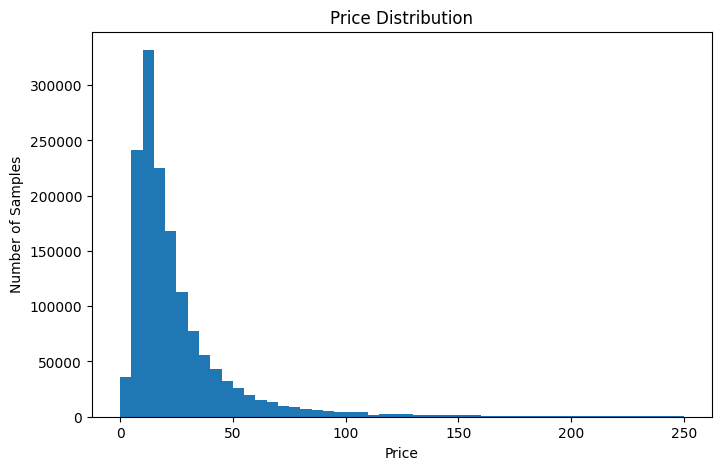

In [21]:
# Chart - 1 Visualization Code For Price Distribution
# Set the figure size
plt.figure(figsize=(8, 5))

# Create a histogram of the 'price' column
plt.hist(train['price'], bins=50, range=[0, 250], label='price')

# Set the title and axis labels
plt.title('Price Distribution', fontsize=12)
plt.xlabel('Price', fontsize=10)
plt.ylabel('Number of Samples', fontsize=10)

# Display the plot
plt.show()

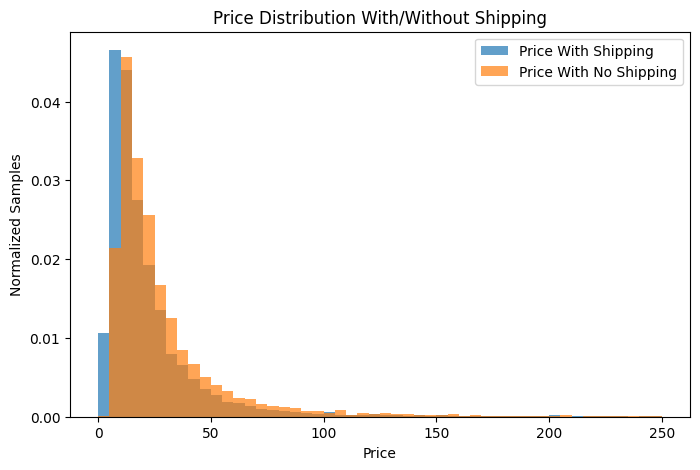

In [22]:
# Filter data for items with shipping (shipping=1) and without shipping (shipping=0)
shipping = train[train['shipping'] == 1]['price']
no_shipping = train[train['shipping'] == 0]['price']

# Set the figure size
plt.figure(figsize=(8, 5))

# Create histograms for both cases
plt.hist(shipping, bins=50, density=True, range=[0, 250], alpha=0.7, label='Price With Shipping')
plt.hist(no_shipping, bins=50, density=True, range=[0, 250], alpha=0.7, label='Price With No Shipping')

# Set the title and axis labels
plt.title('Price Distribution With/Without Shipping', fontsize=12)
plt.xlabel('Price', fontsize=10)
plt.ylabel('Normalized Samples', fontsize=10)

# Add a legend with font size
plt.legend(fontsize=10)

# Display the plot
plt.show()

##### What is/are the insight(s) found from the chart?

From the above chart, we got to know that the most number of sample's price is vary between 10 to 20.

#### Chart - 2 : Distribution of Top 10 Brand

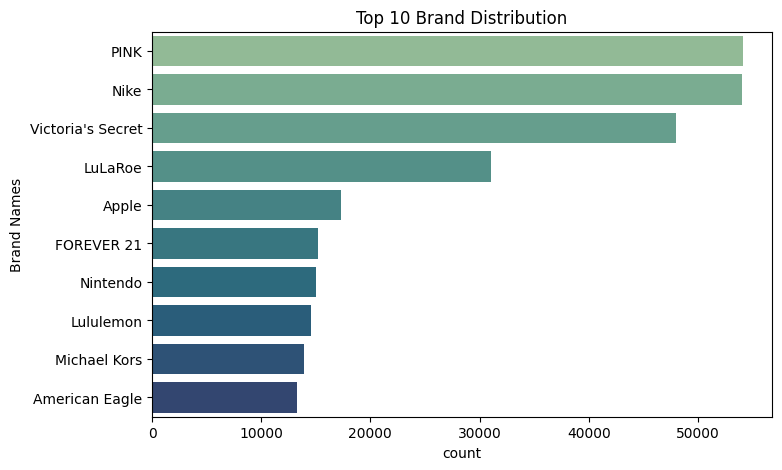

In [23]:
# Chart - 2 Bar Plot Visualization Code for Top 10 Brands Distribution
# Get the top 10 brands by their count and create a DataFrame
top_10_brands = train['brand_name'].value_counts()[:10].reset_index().rename(columns={'index': 'brand_name', 'brand_name': 'count'})

# Set the figure size
plt.figure(figsize=(8, 5))

# Create a bar plot for brand distribution
ax = sns.barplot(x="count", y="brand_name", data=top_10_brands, palette="crest")

# Set the title and axis labels
ax.set_title('Top 10 Brand Distribution', fontsize=12)
plt.ylabel('Brand Names', fontsize=10)

# Show the plot
plt.show()

##### What is/are the insight(s) found from the chart?

From above bar plot we can clearly see that the most popular brands are PINK, Nike, followed by Victoria's Secret and LuLaRoe.

#### Chart - 3 : Distribution of Top 10 Expensive Brands

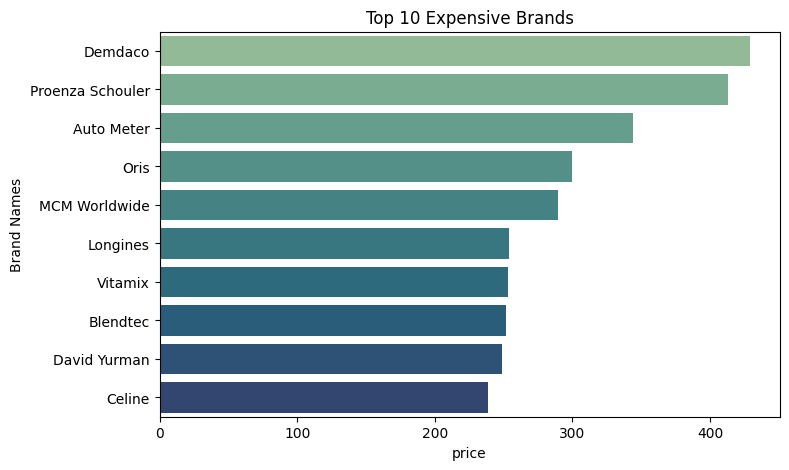

In [24]:
# Chart - 3 Bar Plot Visualization Code for Top 10 Expensive Brands Distribution
# Calculate the mean price for the top 10 brands
top10_brand = train.groupby('brand_name').mean()
df_expPrice = pd.DataFrame(top10_brand['price'].nlargest(10).reset_index())

# Set the figure size
plt.figure(figsize=(8, 5))

# Create a bar plot for the top 10 expensive brands using the defined color palette
ax = sns.barplot(x="price", y="brand_name", data=df_expPrice, palette="crest")

# Set the title and axis labels
ax.set_title('Top 10 Expensive Brands', fontsize=12)
plt.ylabel('Brand Names', fontsize=10)

# Show the plot
plt.show()

##### What is/are the insight(s) found from the chart?

From above bar plot we found that the Demdaco, Proenza Schouler are top most expensive brands followed by Auto Meter, Oris and MCM Worldwide.

#### Chart - 4 : Distribution of Top 10 Main Categories

In [25]:
# Define a function to split the category name into main, sub1, and sub2 categories
def transform_category_name(category_name):
    try:
        main, sub1, sub2 = category_name.split('/')
        return main, sub1, sub2
    except:
        return np.nan, np.nan, np.nan

# Apply the transformation function to the 'category_name' column and create new columns
train['category_main'], train['category_sub1'], train['category_sub2'] = zip(*train['category_name'].apply(transform_category_name))

# Create a DataFrame with the main, sub1, sub2 categories, and the 'price' column
cat_train = train[['category_main', 'category_sub1', 'category_sub2', 'price']]

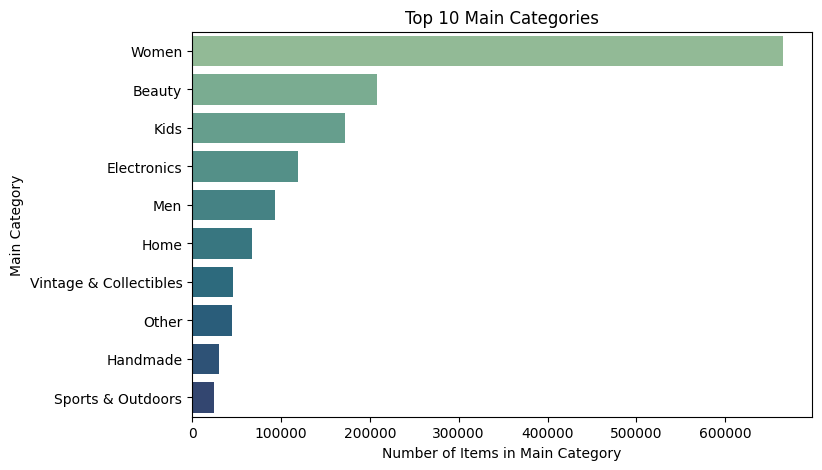

In [26]:
# Chart - 4 Count Plot Visualization Code for Top 10 Main Categories
# Set the figure size for the plot
plt.figure(figsize=(8, 5))

# Create a count plot for the top 10 main categories
sns.countplot(y=train['category_main'], order=train['category_main'].value_counts().index, orient='v', palette="crest")

# Set the title with a larger font size
plt.title('Top 10 Main Categories', fontsize=12)

# Set the y-axis label and x-axis label with appropriate font sizes
plt.ylabel('Main Category', fontsize=10)
plt.xlabel('Number of Items in Main Category', fontsize=10)

# Show the plot
plt.show()

##### What is/are the insight(s) found from the chart?

From above graph, it is observed that Women is the top most main category. Followed by Beauty, Kids and Electronics.

#### Chart - 5 : Category Distribution With/Without Brand

In [27]:
# Create a "no_brand" column
train['no_brand'] = train['brand_name'].isnull()

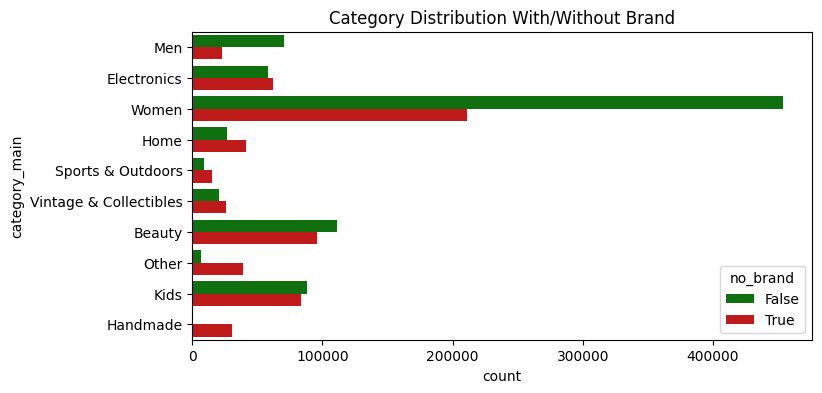

In [28]:
# Chart - 5 Count Plot Visualization Code for Category Distribution With/Without Brand
# Set the figure size for the plot
f, ax = plt.subplots(figsize=(8, 4))

# Create a count plot for the distribution of categories with and without brand
sns.countplot(y='category_main', hue='no_brand', data=train, palette=['green', '#db0000'])

# Set the title
ax.set_title('Category Distribution With/Without Brand', fontsize=12)

# Show the plot
plt.show()

##### What is/are the insight(s) found from the chart?

From above graph, it is observed that category distribution with and without brand, both are high for women category.

#### Chart - 6 : Distribution of Top 10 2nd Categories

In [29]:
# Group the data by 'category_sub2' and calculate the mean price
df = cat_train.groupby(['category_sub2'])['price'].agg(['mean']).reset_index()

# Rename the columns for clarity
df = df.rename(columns={'category_sub2': 'Sub Category 2', 'mean': 'Mean Price'})

# Sort the DataFrame by mean price in descending order and select the top 10 rows
df = df.sort_values('Mean Price', ascending=False).head(10)

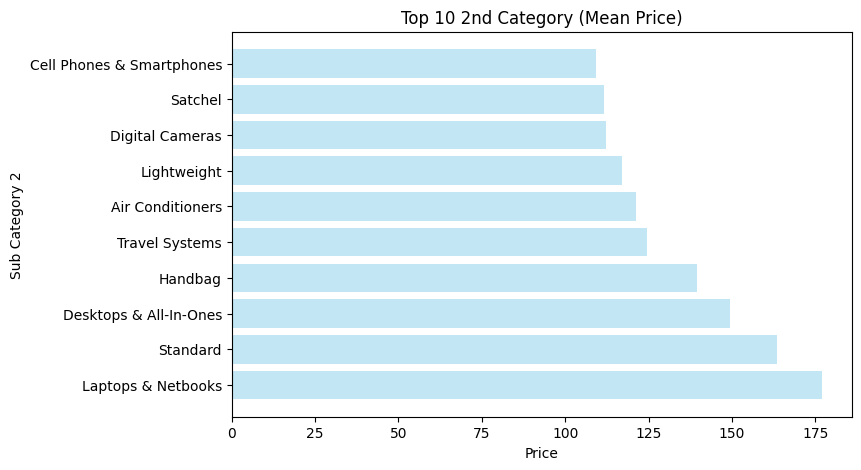

In [30]:
# Chart - 6 Count Plot Visualization Code for Top 10 2nd Category
# Set the figure size for the plot
plt.figure(figsize=(8, 5))

# Create a horizontal bar plot
plt.barh(range(0, len(df)), df['Mean Price'], align='center', alpha=0.5, color='skyblue')

# Set the y-axis labels to display the subcategories
plt.yticks(range(0, len(df)), df['Sub Category 2'], fontsize=10)

# Set the x-axis label, y-axis label, and title
plt.xlabel('Price', fontsize=10)
plt.ylabel('Sub Category 2', fontsize=10)
plt.title('Top 10 2nd Category (Mean Price)', fontsize=12)

# Show the plot
plt.show()

##### What is/are the insight(s) found from the chart?

From the above chart we come to know that compare to the mean price, Cell Phones & Smartphones are in the top. Followed by Satchel, Digital Cameras, Lightweight and Air Conditioners are in the top of 2nd category list.

#### Chart - 7 : Distribution of Top 10 1st Categories

In [31]:
# Group by the 1st subcategory and calculate the mean price
df = cat_train.groupby(['category_sub1'])['price'].agg(['mean']).reset_index().rename(columns={'index': 'main', 'category_main':'count'})

# Sort the data by mean price in descending order and select the top 10
df = df.sort_values('mean', ascending=False).head(10)

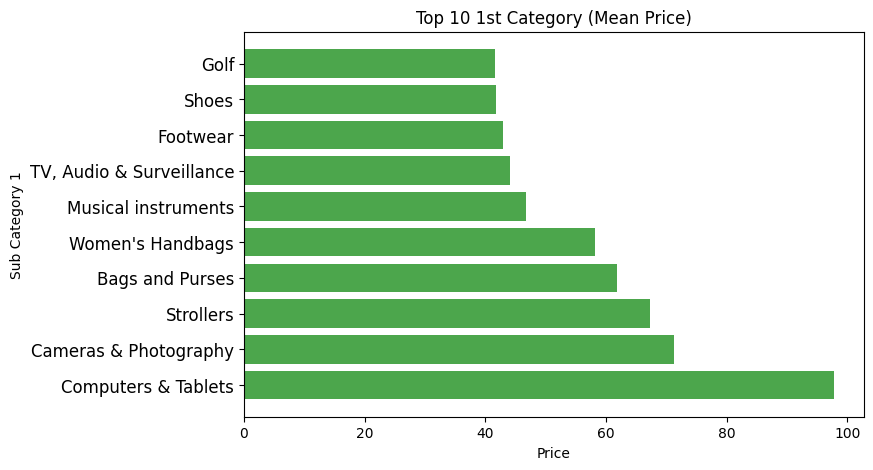

In [32]:
# Chart - 7 Count Plot Visualization Code for Top 10 1st Category
# Set the figure size for the plot
plt.figure(figsize=(8, 5))

# Create a horizontal bar plot with a different color
plt.barh(range(0, len(df)), df['mean'], align='center', alpha=0.7, color='green')

# Set the y-axis labels to display the 1st subcategories
plt.yticks(range(0, len(df)), df['category_sub1'], fontsize=12)

# Set the x-axis label, y-axis label, and title
plt.xlabel('Price', fontsize=10)
plt.ylabel('Sub Category 1', fontsize=10)
plt.title('Top 10 1st Category (Mean Price)', fontsize=12)

# Show the plot
plt.show()

##### What is/are the insight(s) found from the chart?

From the above chart we come to know that compare to the mean price, Golf, Shoes are in the top. Followed by Footwear, TV, Audio and Surveillance are in the top of 1st category list.

#### Chart - 8 : Correlation Heatmap

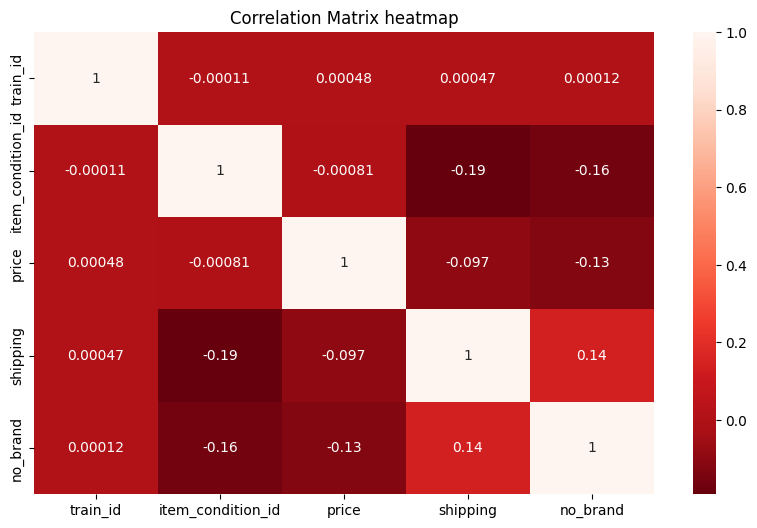

In [33]:
# Correlation Heatmap Visualization Code
corr_matrix = train.corr()

# Plot Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='Reds_r')

# Setting Labels
plt.title('Correlation Matrix heatmap')

# Display Chart
plt.show()

##### What is/are the insight(s) found from the chart?

'no_brand' and 'shipping' are highly negatively correlated with 'item_condition_id'.

## ***5. Feature Engineering & Data Pre-processing***

### 1. Textual Data Preprocessing
(It's mandatory for textual dataset i.e., NLP, Sentiment Analysis, Text Clustering etc.)

#### 1. Lower Casing

In [34]:
# Lower Casing
# Define a function to convert text into lower cases
def to_lower(x):
  return x.lower()

# Apply the to_lower() function to the 'item_description' and 'name' column of the combined DataFrame
combined['name'] = combined['name'].apply(to_lower)
combined['item_description'] = combined['item_description'].apply(to_lower)

# Apply the to_lower() function to the 'item_description' and 'name' column of the ML combined DataFrame
combined_ML['name'] = combined_ML['name'].apply(to_lower)
combined_ML['item_description'] = combined_ML['item_description'].apply(to_lower)

#### 2. Removing Punctuations

In [35]:
# Remove Punctuations
# Define a function to remove punctuations from text
def remove_punctuation(text):
    '''a function for removing punctuation'''
    # Replace each punctuation mark with no space, effectively deleting it from the text
    translator = str.maketrans('', '', string.punctuation)
    text_without_punct = text.translate(translator)
    return text_without_punct

# Apply the remove_punctuation() function to the 'item_description' and 'name' column of the combined DataFrame
combined['name'] = combined['name'].apply(remove_punctuation)
combined['item_description'] = combined['item_description'].apply(remove_punctuation)

# Apply the remove_punctuation() function to the 'item_description' and 'name' column of the ML combined DataFrame
combined_ML['name'] = combined_ML['name'].apply(remove_punctuation)
combined_ML['item_description'] = combined_ML['item_description'].apply(remove_punctuation)

#### 3. Removing URLs & Removing words and digits contain digits.

In [36]:
# Remove URLs & Remove words and digits contain digits
# Define a function to remove digits from text
def remove_digits(x):
    x = ''.join([i for i in x if not i.isdigit()])
    return x

# Apply the remove_digits() function to the 'item_description' and 'name' column of the combined DataFrame
combined['name'] = combined['name'].apply(remove_digits)
combined['item_description'] = combined['item_description'].apply(remove_digits)

# Apply the remove_digits() function to the 'item_description' and 'name' column of the ML combined DataFrame
combined_ML['name'] = combined_ML['name'].apply(remove_digits)
combined_ML['item_description'] = combined_ML['item_description'].apply(remove_digits)

#### 4. Removing Stopwords

In [37]:
# Remove Stopwords
# Since the language is english, we need to import english stop words
stop_words = nltk.corpus.stopwords.words('english')

def remove_stop_words(x):
  ''' function to remove stop words'''
  x = x.split()
  res = ''
  for word in x:
    if word not in stop_words:
      res = res + ' ' + word
  return res

# Apply the remove_stop_words() function to the 'item_description' and 'name' column of the combined DataFrame
combined['name'] = combined['name'].apply(remove_stop_words)
combined['item_description'] = combined['item_description'].apply(remove_stop_words)

# Apply the remove_stop_words() function to the 'item_description' and 'name' column of the ML combined DataFrame
combined_ML['name'] = combined_ML['name'].apply(remove_stop_words)
combined_ML['item_description'] = combined_ML['item_description'].apply(remove_stop_words)

#### 5. Text Vectorization

In [38]:
# Vectorizing Text
# Create the object of Count Vectorizer
cv = CountVectorizer(min_df=10)
# setting min_df = 10

# Fit the vectorizer using the name column
X_name = cv.fit_transform(combined['name'])

In [39]:
X_name

<2175894x20470 sparse matrix of type '<class 'numpy.int64'>'
	with 8148734 stored elements in Compressed Sparse Row format>

In [40]:
# Vectorizing Text
# Create the object of Count Vectorizer
cv = CountVectorizer()

# Fit the vectorizer using the category_name column
X_category = cv.fit_transform(combined['category_name'])

In [41]:
X_category

<2175894x1022 sparse matrix of type '<class 'numpy.int64'>'
	with 8711929 stored elements in Compressed Sparse Row format>

In [42]:
# Vectorizing Text
# Create the object of Tfidf Vectorizer
tv = TfidfVectorizer(max_features=55000, ngram_range=(1, 2), stop_words='english')

# Fit the vectorizer using the item_description column
X_description = tv.fit_transform(combined['item_description'])

In [43]:
# Vectorizing Text
# Create the object of Label Binarizer
lb = LabelBinarizer(sparse_output=True)

# Fit the Label Binarizer using the brand_name column
X_brand = lb.fit_transform(combined['brand_name'])

### 2. CSR_Matrix & Sparse Matrices

In [44]:
# Create our final sparse matrix
X_dummies = csr_matrix(pd.get_dummies(combined[['item_condition_id', 'shipping']], sparse=True).values)

# Combine everything together
sparse_merge = hstack((X_dummies, X_description, X_brand, X_category, X_name)).tocsr()

### 3. Data Splitting

In [45]:
# Split the sparse_merge dataset into the training and test sets
X_train_sparse = sparse_merge[:train_size]

X_test = sparse_merge[train_size:]

####Cross Validation

In [46]:
# Specify the proportion of data for the validation set
eval_size = 0.10

# Create KFold cross-validation object
kf = KFold(n_splits=round(1. / eval_size))

# Initialize variables to store train and validation indices
train_indices, valid_indices = None, None

# Loop through the KFold splits
for train_index, valid_index in kf.split(X_train_sparse):
    train_indices, valid_indices = train_index, valid_index
    break  # Stop after the first fold

# Split the dataset into training and validation sets
X_train, y_train = X_train_sparse[train_indices], y[train_indices]
X_valid, y_valid = X_train_sparse[valid_indices], y[valid_indices]

## ***6. ML Model Implementation***

In [47]:
def rmsle(y, y0):
    """
    Calculate the Root Mean Square Error (RMSE) between two arrays.

    Parameters:
    y (array-like): Ground truth values.
    y0 (array-like): Predicted values.

    Returns:
    float: The RMSE between y and y0.
    """
    assert len(y) == len(y0)
    return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y0), 2)))

### ML Model - 1 : Linear Regression

In [48]:
# ML Model - 1 Implementation
# Measure the start time
start_time = time.time()

# Create a Linear Regression model
model = LinearRegression()

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the validation set
preds_valid = model.predict(X_valid)

# Calculate the time taken for Linear Regression training
training_time = time.time() - start_time

# Calculate and print the Root Mean Squared Logarithmic Error (RMSLE) on the validation set
rmsle_score = rmsle(np.expm1(y_valid), np.expm1(preds_valid))
print('[{}] Linear Regression completed.'.format(training_time))
print("Linear Regression RMSLE: " + str(rmsle_score))

[1662.7852520942688] Linear Regression completed.
Linear Regression RMSLE: 0.474766633041383


In [49]:
# Transform the prices back to its original price
np.expm1(preds_valid)

array([  9.44882252, 105.5014096 ,   9.43550168, ...,  29.3413428 ,
         8.71841308,  11.86833571])

#### Explain the ML Model used and it's performance.

The Linear Regression model is a straightforward and interpretable algorithm commonly used for regression tasks. It works by finding the linear relationship between the input features and the target variable, which, in this case, is the price of products.

The performance of the Linear Regression model, as measured by the Root Mean Squared Logarithmic Error (RMSLE), resulted in a value of 0.4748. The RMSLE is a metric commonly used to evaluate regression models, and a lower RMSLE indicates a better model performance.

### ML Model - 2 : Random Forest

In [50]:
# ML Model - 2 Implementation
# Create a Random Forest model with specified parameters
model2 = RandomForestRegressor(
    n_estimators=100,        # Adjust the number of trees
    max_depth=10,            # Limit tree depth
    min_samples_split=5,     # Increase minimum samples per split
    max_features='sqrt',     # Set max features
    n_jobs=-1                # Use all available CPU cores
)

# Measure the start time
start_time = time.time()

# Train the Random Forest model on the training data
model2.fit(X_train, y_train)

# Make predictions on the validation set
rf_pred = model2.predict(X_valid)

# Calculate and print the time taken for Random Forest training
training_time = time.time() - start_time

# Calculate and print the Root Mean Squared Logarithmic Error (RMSLE) on the validation set
rmsle_score = rmsle(np.expm1(y_valid), np.expm1(rf_pred))
print('[{}] Random Forest completed.'.format(training_time))
print("Random Forest RMSLE: " + str(rmsle_score))

[129.50164103507996] Random Forest completed.
Random Forest RMSLE: 0.7191895613683609


In [51]:
# Transform the prices back to its original price
np.expm1(rf_pred)

array([17.89051842, 20.09253648, 17.80349799, ..., 18.08908315,
       17.50135945, 18.17468179])

#### Explain the ML Model used and it's performance.

Random Forest is an ensemble learning technique based on decision trees. It combines multiple decision trees to make predictions and offers advantages such as handling non-linear relationships, feature importance estimation, and robustness to outliers.

The performance of the Random Forest model, as assessed by the Root Mean Squared Logarithmic Error (RMSLE), resulted in a value of 0.7192. The RMSLE is a common metric used to evaluate regression models, where a lower RMSLE indicates better performance. In this case, the RMSLE of 0.7192 reflects the model's accuracy in predicting prices for online sellers.

### ML Model - 3 : Ridge Regression

In [52]:
# ML Model - 3 Implementation
# Create a Ridge Regression model
model3 = Ridge(max_iter=100)

# Train the model and make predictions as usual
model3.fit(X_train, y_train)
ridge_pred = model3.predict(X_valid)

# Calculate and print the time taken for Random Forest training
training_time = time.time() - start_time

# Calculate and print the Root Mean Squared Logarithmic Error (RMSLE) on the validation set
rmsle_score = rmsle(np.expm1(y_valid), np.expm1(ridge_pred))
print('[{}] Ridge Regression completed.'.format(training_time))
print("Ridge Regression RMSLE: " + str(rmsle_score))

[162.71309304237366] Ridge Regression completed.
Ridge Regression RMSLE: 0.47446619070156415


In [53]:
# Transform the prices back to its original price
np.expm1(ridge_pred)

array([ 9.39930434, 87.16384605,  8.78939183, ..., 23.77224133,
        8.66421372, 11.90701092])

#### Explain the ML Model used and it's performance.

Ridge Regression is a linear regression technique that addresses multicollinearity and overfitting by introducing L2 regularization, which penalizes large coefficients. It's especially useful when dealing with datasets that have highly correlated features.

The performance of the Ridge Regression model, as evaluated by the Root Mean Squared Logarithmic Error (RMSLE), resulted in a value of 0.4745. RMSLE is a widely-used metric for assessing regression models, where a lower RMSLE signifies better predictive accuracy. In this instance, an RMSLE of 0.4745 indicates the model's effectiveness in forecasting prices for online sellers.

The Ridge Regression model has displayed strong performance, with an RMSLE of 0.4745, demonstrating its capacity to make accurate price predictions. It is particularly well-suited for situations where the dataset exhibits multicollinearity among predictor variables.

### Which ML model did i choose from the above created models as my final prediction model and why?

From the RMSLE values we can see that the Ridge Regression model is best model for our data.

Here we get the RMSLE value is 0.4745. Lower RMSLE signifies better predictive accuracy.

The Ridge Regression model is a valuable choice for the price prediction task, with an RMSLE of 0.4745.

While the model has shown remarkable performance, further refinements and optimizations may be explored to fine-tune its predictive capabilities and meet the specific demands of the online seller recommendation project.

## ***7. Price Recommendation System***

In [54]:
# Make price predictions on the test dataset
preds = model3.predict(X_test)

# Convert the predictions back to the original scale from logarithmic scale
predicted_prices = np.expm1(preds)

# Assign the predicted prices to the "price" column in the submission DataFrame
submission["price"] = predicted_prices

# Save the submission DataFrame to a CSV file without index
submission.to_csv("submission_ridge.csv", index=False)

In [55]:
# Display the submission DataFrame
submission

,test_id,price
0,0,10.455670
1,1,12.991942
2,2,48.457070
3,3,15.931137
4,4,7.379272
...,...,...
693354,693354,23.353390
693355,693355,27.991315
693356,693356,6.474056
693357,693357,17.066524


# **Conclusion**

**Exploratory Data Analysis (EDA) Insights:**

- Most items fall within the 10 to 20 price range, suggesting a popular price bracket.
- Prominent brands include PINK, Nike, Victoria's Secret, and LuLaRoe.
- High-end brands such as Demdaco and Proenza Schouler were identified.
- Women's products dominate primary categories, led by Women, Beauty, Kids, and Electronics.
- Women's category shows substantial items with and without brands.

**Machine Learning Model Insights:**

- **Linear Regression:** Achieved an RMSLE of 0.4748, indicating reasonable accuracy.
- **Random Forest:** RMSLE of 0.7192, showing potential for further refinement.
- **Ridge Regression:** Impressive RMSLE of 0.4745, offering superior predictive accuracy.

So, The Ridge Regression model excels in price prediction, proving valuable for online sellers.

This summary provides key findings from the project and highlights the performance of machine learning models.